In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from PIL import Image
import os
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

from tqdm import tqdm


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertModel

In [2]:
# 완벽한 실험 재현성을 위한 랜덤제어
random_seed = 28
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(random_seed)

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3060


In [77]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
}

In [78]:
image_path = "C:/Users/ANDlab3/Desktop/paper/fashion-dataset/data/"
image_datasets = {x: datasets.ImageFolder(os.path.join(image_path, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [79]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6475
     Root location: C:/Users/ANDlab3/Desktop/paper/fashion-dataset/data/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 925
     Root location: C:/Users/ANDlab3/Desktop/paper/fashion-dataset/data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 1850
     Root location: C:/Users/ANDlab3/Desktop/paper/fashion-dataset/data/test
     StandardTransform
 Transfo

In [80]:
dataset_sizes

{'train': 6475, 'val': 925, 'test': 1850}

In [81]:
class_num = len(class_names)

# Vison Module

In [19]:
model_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/model/"

vision_module = models.resnet50(pretrained=False)
num_ftrs = vision_module.fc.in_features
vision_module.fc = nn.Linear(num_ftrs, len(class_names))

vision_module = vision_module.to(device) # 모델 선언
vision_module.load_state_dict(torch.load(model_path+'vision_model.pt')) # fine tune 파라메타 불러오기

<All keys matched successfully>

In [21]:
vision_module

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# 파라메타 번호 확인 하기
i = 0
for name, param in vision_module.named_parameters():
    
    print(i,name)
    i+= 1

0 conv1.weight
1 bn1.weight
2 bn1.bias
3 layer1.0.conv1.weight
4 layer1.0.bn1.weight
5 layer1.0.bn1.bias
6 layer1.0.conv2.weight
7 layer1.0.bn2.weight
8 layer1.0.bn2.bias
9 layer1.0.conv3.weight
10 layer1.0.bn3.weight
11 layer1.0.bn3.bias
12 layer1.0.downsample.0.weight
13 layer1.0.downsample.1.weight
14 layer1.0.downsample.1.bias
15 layer1.1.conv1.weight
16 layer1.1.bn1.weight
17 layer1.1.bn1.bias
18 layer1.1.conv2.weight
19 layer1.1.bn2.weight
20 layer1.1.bn2.bias
21 layer1.1.conv3.weight
22 layer1.1.bn3.weight
23 layer1.1.bn3.bias
24 layer1.2.conv1.weight
25 layer1.2.bn1.weight
26 layer1.2.bn1.bias
27 layer1.2.conv2.weight
28 layer1.2.bn2.weight
29 layer1.2.bn2.bias
30 layer1.2.conv3.weight
31 layer1.2.bn3.weight
32 layer1.2.bn3.bias
33 layer2.0.conv1.weight
34 layer2.0.bn1.weight
35 layer2.0.bn1.bias
36 layer2.0.conv2.weight
37 layer2.0.bn2.weight
38 layer2.0.bn2.bias
39 layer2.0.conv3.weight
40 layer2.0.bn3.weight
41 layer2.0.bn3.bias
42 layer2.0.downsample.0.weight
43 layer2.0.do

In [23]:
# 합성곱 층은 0~9까지이다. 따라서 9번째 변수까지 역추적을 비활성화 한 후 for문을 종료한다.

for i, (name, param) in enumerate(vision_module.named_parameters()):
    
    param.requires_grad = False
    if i == 160:
        print('end')

end


In [48]:
# vision module freeze check
print(vision_module.conv1.weight.requires_grad)
print(vision_module.layer1[0].conv1.weight.requires_grad)
print(vision_module.fc.weight.requires_grad)
print(vision_module.fc.bias.requires_grad)

False
False
False
False


# NLP Module

In [50]:
nlp_train_path = "C:/Users/ANDlab3/Desktop/NLP/split_data/train.csv"
nlp_val_path = "C:/Users/ANDlab3/Desktop/NLP/split_data/val.csv"
nlp_test_path = "C:/Users/ANDlab3/Desktop/NLP/split_data/test.csv"

In [52]:
nlp_train_data = pd.read_csv(nlp_train_path)
nlp_val_data = pd.read_csv(nlp_val_path)
nlp_test_data = pd.read_csv(nlp_test_path)

In [55]:
X_train = nlp_train_data['productDisplayName']
y_train = nlp_train_data['label']

In [56]:
X_val = nlp_val_data['productDisplayName']
y_val = nlp_val_data['label']

In [57]:
X_test = nlp_test_data['productDisplayName']
y_test = nlp_test_data['label']

In [64]:
nlp_train_data[:8]

,articleType,image,productDisplayName,label
0,Tshirts,3991.jpg,Mr.Men Men's Wave Rider White T-shirt,34
1,Tshirts,13423.jpg,United Colors of Benetton Men Solid Navy Blue ...,34
2,Tshirts,7281.jpg,Batman Men's The Dark Knight Light Grey T-shirt,34
3,Tshirts,10854.jpg,Wrangler Men Green Polo T-shirt,34
4,Tshirts,35876.jpg,Marvel Boys Comics Orange T-shirt,34
5,Tshirts,36562.jpg,Jack & Jones Men Dino White T-shirt,34
6,Tshirts,6765.jpg,Timberland Men's Saco River White T-shirt,34
7,Tshirts,1165.jpg,Nike Mean Team India Cricket Jersey,34


In [82]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [83]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [84]:
classes

tensor([0, 0, 0, 0, 0, 0, 0, 0])

In [89]:
for i in classes:
    print(class_names[i])

Backpacks
Backpacks
Backpacks
Backpacks
Backpacks
Backpacks
Backpacks
Backpacks


In [90]:
class_names

['Backpacks',
 'Belts',
 'Bra',
 'Briefs',
 'Caps',
 'Casual Shoes',
 'Clutches',
 'Deodorant',
 'Dresses',
 'Earrings',
 'Flats',
 'Flip Flops',
 'Formal Shoes',
 'Handbags',
 'Heels',
 'Jackets',
 'Jeans',
 'Kurtas',
 'Lipstick',
 'Nail Polish',
 'Perfume and Body Mist',
 'Sandals',
 'Sarees',
 'Shirts',
 'Shorts',
 'Socks',
 'Sports Shoes',
 'Sunglasses',
 'Sweaters',
 'Sweatshirts',
 'Ties',
 'Tops',
 'Track Pants',
 'Trousers',
 'Tshirts',
 'Wallets',
 'Watches']

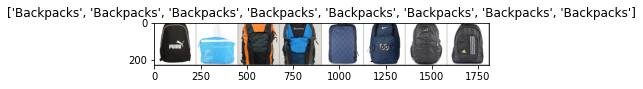

In [85]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [67]:
dataloaders['train']

In [68]:
for i in dataloaders['train']:
    print(i)
    break

[tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 